<a href="https://colab.research.google.com/github/alxgrin/kaggle/blob/main/andrewmvd/face-mask-detection/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection
853 images belonging to 3 classes.

![img](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F793761%2Fd0744f78b0471c0605b98debd7b2d88d%2FUntitled.png?generation=1590132045583855&alt=media)

**About this Data**

> Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.
> This dataset contains **853** images belonging to the **3** classes, as well as their bounding boxes in the PASCAL VOC format.
> The classes are:
>
> - With mask;
> - Without mask;
> - Mask worn incorrectly.

**How to Use this Data**

> ### Suggested Notebooks
>
> - [Pytorch FasterRCNN](https://www.kaggle.com/daniel601/pytorch-fasterrcnn) by [Daniel](https://www.kaggle.com/daniel601)
>
> ### More Datasets
>
> For more datasets, click [here](https://www.kaggle.com/andrewmvd/datasets).

**How to Cite this Dataset**

If you use this dataset, please credit the authors

**BibTeX**

> [@misc](https://www.kaggle.com/misc){make ml,
> title={Mask Dataset},
> url={https://makeml.app/datasets/mask},
> journal={Make ML}
> }

**License**

> Public Domain

**Splash Banner**

> Photo by engin akyurt on [Unsplash](https://unsplash.com/photos/AS-ksEGPa2c)

Link: https://www.kaggle.com/andrewmvd/face-mask-detection

In [ ]:
!pip install -U xmltodict

In [ ]:
from os import listdir
from os.path import isfile, join

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import xmltodict
from PIL import Image
from skimage import io
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/kaggle_data/andrewmvd_face-mask-detection"
!ls $DATA_PATH

annotations  images


In [ ]:
IMAGE_PATH = os.path.join(DATA_PATH, "images")
IMAGE_PATH

'/content/drive/MyDrive/kaggle_data/andrewmvd_face-mask-detection/images'

# Подготовка данных

In [ ]:
annotations_path = join(DATA_PATH, "annotations")
annotations_files = [
    f for f in listdir(annotations_path) if isfile(join(annotations_path, f))
]

annotations = []

for annotation_file in tqdm(annotations_files):
    annotation_file = join(DATA_PATH, "annotations", annotation_file)
    with open(annotation_file) as f:
        annotation = xmltodict.parse(f.read())["annotation"]
        if type(annotation["object"]) != list:
            annotation["object"] = [annotation["object"]]
        annotations.append(annotation)

len(annotations)

  0%|          | 0/853 [00:00<?, ?it/s]

853

In [ ]:
df = pd.json_normalize(annotations)
df

,folder,filename,segmented,object,size.width,size.height,size.depth
0,images,maksssksksss109.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",400,400,3
1,images,maksssksksss0.png,0,"[{'name': 'without_mask', 'pose': 'Unspecified...",512,366,3
2,images,maksssksksss107.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",301,400,3
3,images,maksssksksss100.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",400,226,3
4,images,maksssksksss11.png,0,"[{'name': 'mask_weared_incorrect', 'pose': 'Un...",400,267,3
...,...,...,...,...,...,...,...
848,images,maksssksksss165.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",450,463,3
849,images,maksssksksss249.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",400,267,3
850,images,maksssksksss512.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",400,280,3
851,images,maksssksksss148.png,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ...",400,364,3


In [ ]:
items = []
for idx in tqdm(range(df.shape[0])):
    item = df.iloc[idx]
    df1 = pd.json_normalize(item["object"])
    df1["filename"] = item["filename"]
    items.append(df1)

df_object = pd.concat(items)
df_object

  0%|          | 0/853 [00:00<?, ?it/s]

,name,pose,truncated,occluded,difficult,bndbox.xmin,bndbox.ymin,bndbox.xmax,bndbox.ymax,filename
0,with_mask,Unspecified,0,0,0,216,92,372,251,maksssksksss109.png
0,without_mask,Unspecified,0,0,0,79,105,109,142,maksssksksss0.png
1,with_mask,Unspecified,0,0,0,185,100,226,144,maksssksksss0.png
2,without_mask,Unspecified,0,0,0,325,90,360,141,maksssksksss0.png
0,with_mask,Unspecified,0,0,0,121,192,212,312,maksssksksss107.png
...,...,...,...,...,...,...,...,...,...,...
2,without_mask,Unspecified,0,0,0,116,104,140,144,maksssksksss148.png
3,with_mask,Unspecified,0,0,0,151,89,247,205,maksssksksss148.png
4,without_mask,Unspecified,0,0,0,325,77,397,156,maksssksksss148.png
5,with_mask,Unspecified,0,0,0,243,120,283,179,maksssksksss148.png


## Визуализация целевой переменной

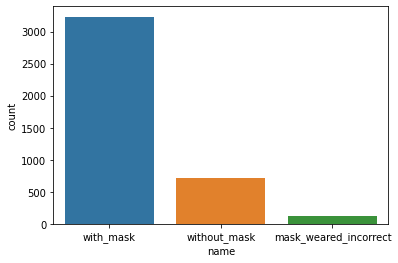

In [ ]:
# https://www.kaggle.com/sandhyakrishnan02/face-mask-detection-using-torch
sns.countplot(x=df_object["name"])

Добавление цветового выделения для каждого таргета (целевой переменной)

*   Green --> with_mask
*   Red --> without_mask
*   Yellow -- > mask_weared_incorrect

In [ ]:
df_object[df_object["filename"] == "maksssksksss0.png"]

,name,pose,truncated,occluded,difficult,bndbox.xmin,bndbox.ymin,bndbox.xmax,bndbox.ymax,filename
0,without_mask,Unspecified,0,0,0,79,105,109,142,maksssksksss0.png
1,with_mask,Unspecified,0,0,0,185,100,226,144,maksssksksss0.png
2,without_mask,Unspecified,0,0,0,325,90,360,141,maksssksksss0.png


In [ ]:
def mask_selection(filename):
    image_path = os.path.join(IMAGE_PATH, filename)
    image = io.imread(image_path)

    fig, ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10, 5)
    fig.suptitle(filename)

    object_list = df_object[df_object["filename"] == filename]
    for idx in range(len(object_list)):
        obj = object_list.iloc[idx]
        x, y, w, h = pd.to_numeric(
            obj[["bndbox.xmin", "bndbox.ymin", "bndbox.xmax", "bndbox.ymax"]]
        )

        edgecolor, color = "g", "green"
        if obj["name"] == "without_mask":
            edgecolor, color = "r", "red"
        elif obj["name"] == "mask_weared_incorrect":
            edgecolor, color = "y", "yellow"

        mpatch = mpatches.Rectangle(
            (x, y),
            w - x,
            h - y,
            linewidth=1,
            edgecolor=edgecolor,
            facecolor="none",
            lw=2,
        )
        ax.add_patch(mpatch)
        rx, ry = mpatch.get_xy()

        ax.annotate(
            obj["name"],
            (rx, ry),
            color=color,
            weight="bold",
            fontsize=10,
            ha="left",
            va="baseline",
        )

    ax.imshow(image)
    ax.add_patch(mpatch)

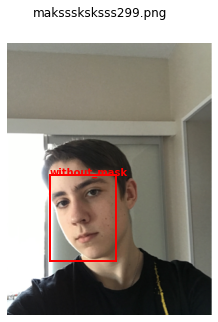

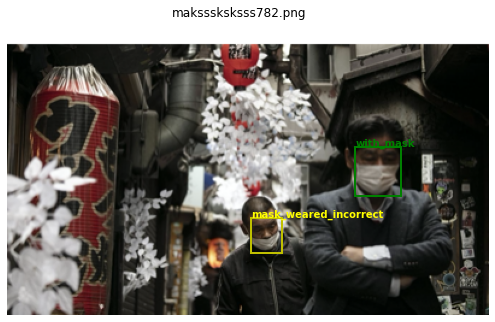

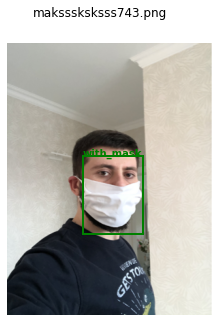

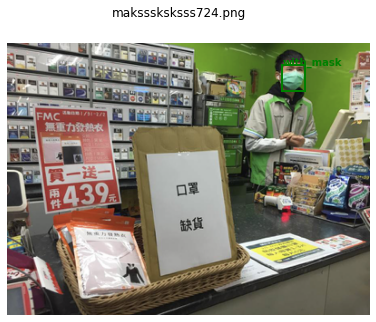

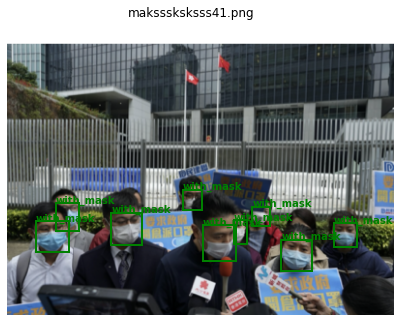

In [ ]:
image_list = df.sample(5)["filename"].tolist()
for filename in image_list:
    mask_selection(filename)

# Создание датасета и лоадеров для обучения

In [ ]:
label_list = df_object["name"].unique()
label_list = {val: idx for idx, val in enumerate(label_list)}
label_list

{'mask_weared_incorrect': 2, 'with_mask': 0, 'without_mask': 1}

In [ ]:
class MaskDataset(Dataset):
    def __init__(self, mask_frame, image_dir, transform=None):
        self.mask_frame = mask_frame
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.mask_frame)

    def __getitem__(self, idx):
        row = self.mask_frame.iloc[idx]
        x, y, w, h = pd.to_numeric(
            row[["bndbox.xmin", "bndbox.ymin", "bndbox.xmax", "bndbox.ymax"]]
        )

        label = label_list[row["name"]]

        image = Image.open(os.path.join(self.image_dir, row["filename"])).convert("RGB")
        image = transforms.functional.crop(image, y, x, h - y, w - x)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
tfs = transforms.Compose(
    [
        transforms.Resize([512, 512]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

train_dataset = MaskDataset(
    mask_frame=df_object, image_dir=join(DATA_PATH, "images"), transform=tfs,
)
len(train_dataset)

4072

In [ ]:
BATCH_SIZE = 32

total_count = len(train_dataset)
train_count, val_count = int(0.7 * total_count), int(0.2 * total_count)
test_count = total_count - (train_count + val_count)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_dataset, (train_count, val_count, test_count)
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

train_count, val_count, test_count

(2850, 814, 408)

# Построение модели и прогнозирование

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [ ]:
class MaskDetectionNN(nn.Module):
    def __init__(self):
        super().__init__()

        # https://pytorch.org/vision/stable/models.html#classification
        # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
        self.model = models.resnet34(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False

        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 3)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MaskDetectionNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def accuracy_score(model, loader, desc=""):
    model.eval()

    accuracy_score = 0

    pbar = tqdm(enumerate(loader), total=len(loader))
    if desc:
        pbar.set_description(desc)

    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)
        accuracy = (y_preds.argmax(dim=1) == labels).float().mean()
        accuracy_score += accuracy.cpu().detach().numpy()

    return accuracy_score / len(loader)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    pbar.set_description("Epoch: %d" % epoch)

    epoch_loss = 0
    epoch_accuracy = 0

    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)
        loss = criterion(y_preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (y_preds.argmax(dim=1) == labels).float().mean()

        epoch_loss += loss.cpu().detach().numpy()
        epoch_accuracy += accuracy.cpu().detach().numpy()

    print(
        "Loss: {}, Train accuracy: {}, Val accuracy: {}".format(
            epoch_loss / len(train_loader),
            epoch_accuracy / len(train_loader),
            accuracy_score(model, val_loader, "Validate accuracy"),
        )
    )

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.4801824586258994, Train accuracy: 0.8204861111111111, Val accuracy: 0.8638392870242779


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.38275987787379157, Train accuracy: 0.8625, Val accuracy: 0.8950892870242779


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.35827823860777747, Train accuracy: 0.875, Val accuracy: 0.8851304971254789


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.34014614505900276, Train accuracy: 0.8767361111111112, Val accuracy: 0.8959478048177866


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.34140442891253364, Train accuracy: 0.8840277777777777, Val accuracy: 0.9038461538461539


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.3142151665356424, Train accuracy: 0.8930555555555556, Val accuracy: 0.9026442307692307


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.29864365980029106, Train accuracy: 0.9010416666666666, Val accuracy: 0.8986950562550471


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.28710105642676353, Train accuracy: 0.90625, Val accuracy: 0.8871909357034243


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.2804942419131597, Train accuracy: 0.9052083333333333, Val accuracy: 0.9043612663562481


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Loss: 0.27919817715883255, Train accuracy: 0.9052083333333333, Val accuracy: 0.8968063203188089


# Проверка результатов

In [ ]:
test_accuracy = accuracy_score(model, test_loader, "Test accuracy")
test_accuracy

  0%|          | 0/13 [00:00<?, ?it/s]

0.8846153846153846